In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, average_precision_score,
                             f1_score, precision_score, recall_score, accuracy_score)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Load the provider-level features dataset
df = pd.read_csv('data/Provider_Level_Features.csv')

print("=" * 70)
print("STEP 1: PREPARE MODELING DATASET")
print("=" * 70)

# Display basic info
print(f"\nDataset Shape: {df.shape}")
print(f"\nColumn Names:\n{df.columns.tolist()}")
print(f"\nFirst Few Rows:")
print(df.head())

STEP 1: PREPARE MODELING DATASET

Dataset Shape: (5410, 40)

Column Names:
['Provider', 'TotalReimbursement', 'AvgReimbursement', 'StdReimbursement', 'MaxReimbursement', 'MinReimbursement', 'TotalDeductible', 'AvgDeductible', 'TotalClaims', 'UniquePatients', 'AvgAge', 'StdAge', 'MinAge', 'MaxAge', 'MaleRatio', 'DeceasedRatio', 'AvgClaimDuration', 'StdClaimDuration', 'MaxClaimDuration', 'AvgAdmissionDuration', 'MaxAdmissionDuration', 'ChronicCond_Alzheimer_Prevalence', 'ChronicCond_Heartfailure_Prevalence', 'ChronicCond_KidneyDisease_Prevalence', 'ChronicCond_Cancer_Prevalence', 'ChronicCond_ObstrPulmonary_Prevalence', 'ChronicCond_Depression_Prevalence', 'ChronicCond_Diabetes_Prevalence', 'ChronicCond_IschemicHeart_Prevalence', 'ChronicCond_Osteoporasis_Prevalence', 'ChronicCond_rheumatoidarthritis_Prevalence', 'ChronicCond_stroke_Prevalence', 'RenalDiseaseIndicator_Prevalence', 'InpatientRatio', 'ClaimsPerPatient', 'ReimbursementPerPatient', 'ReimbursementPerClaim', 'OutpatientRatio',

In [9]:
# Identify target and features
# Assuming 'ExclusionLabel' or similar is the target variable
# Adjust column name based on actual data

# Find the target column (likely named something like 'Excluded', 'ExclusionLabel', 'is_excluded', etc.)
potential_targets = ['ExclusionLabel', 'Excluded', 'is_excluded', 'target', 'label', 'fraud', 'exclusion']
target_col = None

for col in df.columns:
    if col.lower() in [t.lower() for t in potential_targets]:
        target_col = col
        break

# If not found, assume last column or look for binary column
if target_col is None:
    # Check for binary columns
    for col in df.columns:
        if df[col].nunique() == 2 and df[col].dtype in ['int64', 'float64']:
            unique_vals = set(df[col].dropna().unique())
            if unique_vals.issubset({0, 1, 0.0, 1.0}):
                target_col = col
                print(f"Identified potential target column: {col}")
                break

print(f"\nTarget Column: {target_col}")
print(f"\nTarget Distribution:")
print(df[target_col].value_counts())
print(f"\nTarget Percentage:")
print(df[target_col].value_counts(normalize=True) * 100)

# Separate features and target
# Exclude identifier columns
id_columns = ['Provider', 'ProviderID', 'provider_id', 'NPI', 'ID']
exclude_cols = [col for col in df.columns if col in id_columns or col == target_col]

X = df.drop(columns=exclude_cols, errors='ignore')
y = df[target_col]

print(f"\nFeature Matrix Shape: {X.shape}")
print(f"Target Vector Shape: {y.shape}")

# Check for any remaining non-numeric columns
non_numeric = X.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric:
    print(f"\nNon-numeric columns to handle: {non_numeric}")
    # One-hot encode or drop
    X = pd.get_dummies(X, columns=non_numeric, drop_first=True)
    print(f"Shape after encoding: {X.shape}")



Identified potential target column: PotentialFraud_Binary

Target Column: PotentialFraud_Binary

Target Distribution:
PotentialFraud_Binary
0    4904
1     506
Name: count, dtype: int64

Target Percentage:
PotentialFraud_Binary
0    90.64695
1     9.35305
Name: proportion, dtype: float64

Feature Matrix Shape: (5410, 38)
Target Vector Shape: (5410,)

Non-numeric columns to handle: ['PotentialFraud']
Shape after encoding: (5410, 38)



DATASET SPLITS

Set                Samples   Percentage    Pos Class   Pos Rate
------------------------------------------------------------
Training              3246        60.0%          304      9.37%
Validation            1082        20.0%          101      9.33%
Test                  1082        20.0%          101      9.33%

Total                 5410       100.0%


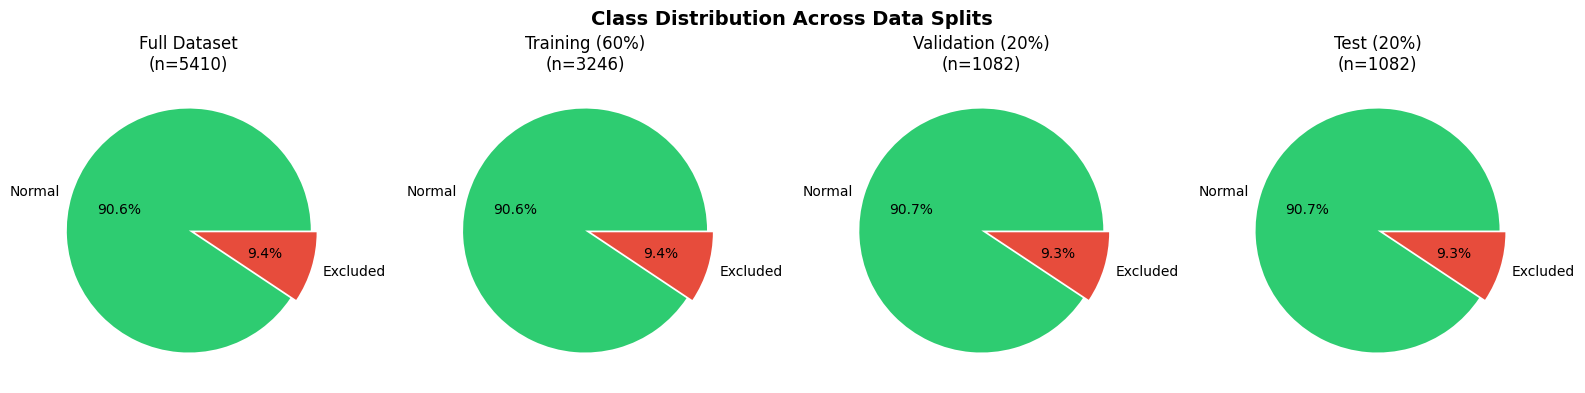

In [ ]:
# First split: 60% train, 40% temp (will become 20% val + 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.40,
    random_state=RANDOM_STATE,
    stratify=y  # Maintain class distribution
)

# Second split: 50% of temp = 20% val, 50% of temp = 20% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=RANDOM_STATE,
    stratify=y_temp
)

print("\n" + "=" * 50)
print("DATASET SPLITS")
print("=" * 50)

print(f"\n{'Set':<15} {'Samples':>10} {'Percentage':>12} {'Pos Class':>12} {'Pos Rate':>10}")
print("-" * 60)

for name, X_set, y_set in [('Training', X_train, y_train),
                            ('Validation', X_val, y_val),
                            ('Test', X_test, y_test)]:
    pos_count = y_set.sum()
    pos_rate = y_set.mean() * 100
    pct = len(y_set) / len(y) * 100
    print(f"{name:<15} {len(y_set):>10} {pct:>11.1f}% {pos_count:>12} {pos_rate:>9.2f}%")

print(f"\n{'Total':<15} {len(y):>10} {'100.0%':>12}")

# Visualize the splits
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

datasets = [('Full Dataset', y), ('Training (60%)', y_train),
            ('Validation (20%)', y_val), ('Test (20%)', y_test)]

for ax, (name, data) in zip(axes, datasets):
    counts = data.value_counts()
    colors = ['#2ecc71', '#e74c3c']
    ax.pie(counts, labels=['Normal', 'Excluded'], autopct='%1.1f%%',
           colors=colors, explode=(0, 0.05))
    ax.set_title(f'{name}\n(n={len(data)})')

plt.suptitle('Class Distribution Across Data Splits', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [11]:
# Check for missing values
print("\n" + "=" * 50)
print("MISSING VALUE ANALYSIS")
print("=" * 50)

missing_train = X_train.isnull().sum()
missing_pct = (missing_train / len(X_train) * 100).round(2)

missing_df = pd.DataFrame({
    'Missing Count': missing_train,
    'Missing %': missing_pct
}).query('`Missing Count` > 0').sort_values('Missing %', ascending=False)

if len(missing_df) > 0:
    print(f"\nFeatures with Missing Values:")
    print(missing_df)

    # Fill missing values with median (from training set only)
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='median')

    X_train_imputed = pd.DataFrame(
        imputer.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )
    X_val_imputed = pd.DataFrame(
        imputer.transform(X_val),
        columns=X_val.columns,
        index=X_val.index
    )
    X_test_imputed = pd.DataFrame(
        imputer.transform(X_test),
        columns=X_test.columns,
        index=X_test.index
    )

    X_train, X_val, X_test = X_train_imputed, X_val_imputed, X_test_imputed
    print("\n✓ Missing values imputed with median")
else:
    print("\n✓ No missing values found!")

# Store feature names for later use
feature_names = X_train.columns.tolist()
print(f"\nTotal Features: {len(feature_names)}")


MISSING VALUE ANALYSIS

✓ No missing values found!

Total Features: 38


In [12]:
print("\n" + "=" * 70)
print("STEP 2: HANDLE CLASS IMBALANCE")
print("=" * 70)

# Calculate imbalance ratio
imbalance_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"\nClass Imbalance Ratio: {imbalance_ratio:.2f}:1")
print(f"Minority Class (Excluded): {y_train.sum()} samples ({y_train.mean()*100:.2f}%)")
print(f"Majority Class (Normal): {len(y_train) - y_train.sum()} samples ({(1-y_train.mean())*100:.2f}%)")

# Scale features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


STEP 2: HANDLE CLASS IMBALANCE

Class Imbalance Ratio: 9.68:1
Minority Class (Excluded): 304 samples (9.37%)
Majority Class (Normal): 2942 samples (90.63%)


In [13]:
print("\n" + "-" * 50)
print("METHOD 1: Class Weighting")
print("-" * 50)

# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print(f"\nComputed Class Weights:")
print(f"  Class 0 (Normal): {class_weight_dict[0]:.4f}")
print(f"  Class 1 (Excluded): {class_weight_dict[1]:.4f}")


--------------------------------------------------
METHOD 1: Class Weighting
--------------------------------------------------

Computed Class Weights:
  Class 0 (Normal): 0.5517
  Class 1 (Excluded): 5.3388


## Seif's Work
## Gradient Boosting for Provider Fraud Detection

This notebook focuses on training, validating, and testing a **Gradient Boosting** model
using a 60% / 20% / 20% split.

We will:

1. Load provider-level features
2. Handle class imbalance
3. Train Gradient Boosting
4. Validate on 20% validation data
5. Test on 20% test data
6. Analyze feature importance
7. Interpret Gradient Boosting


In [15]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# ==========================
# LOAD PROVIDER-LEVEL DATA
# ==========================

DATA_PATH = "data/Provider_Level_Features.csv"   # make sure this matches your file name

df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (5410, 40)


,Provider,TotalReimbursement,AvgReimbursement,StdReimbursement,MaxReimbursement,MinReimbursement,TotalDeductible,AvgDeductible,TotalClaims,UniquePatients,...,ChronicCond_rheumatoidarthritis_Prevalence,ChronicCond_stroke_Prevalence,RenalDiseaseIndicator_Prevalence,InpatientRatio,ClaimsPerPatient,ReimbursementPerPatient,ReimbursementPerClaim,OutpatientRatio,PotentialFraud,PotentialFraud_Binary
0,PRV51001,104640,4185.600000,10796.091144,42000,10,5340,213.600000,25,24,...,0.320000,0.240000,0.320000,0.200000,1.041667,4360.000000,4185.600000,0.800000,No,0
1,PRV51003,605670,4588.409091,7309.794729,57000,0,66286,502.166667,132,117,...,0.287879,0.090909,0.219697,0.469697,1.128205,5176.666667,4588.409091,0.530303,Yes,1
2,PRV51004,52170,350.134228,689.963754,3300,0,310,2.080537,149,138,...,0.308725,0.114094,0.154362,0.000000,1.079710,378.043478,350.134228,1.000000,No,0
3,PRV51005,280910,241.124464,491.556392,4080,0,3700,3.175966,1165,495,...,0.284120,0.106438,0.222318,0.000000,2.353535,567.494949,241.124464,1.000000,Yes,1
4,PRV51007,33710,468.194444,1433.769116,10000,0,3264,45.333333,72,58,...,0.305556,0.166667,0.152778,0.041667,1.241379,581.206897,468.194444,0.958333,No,0


In [16]:
# ==========================
# PREPARE FEATURES AND TARGET (NO LEAKAGE)
# ==========================

# 1) Choose the target column
if "PotentialFraud_Binary" in df.columns:
    y = df["PotentialFraud_Binary"]
    print("Using PotentialFraud_Binary as target.")
else:
    # Fallback: build it from PotentialFraud Yes/No
    df["FraudLabel"] = df["PotentialFraud"].map({"No": 0, "Yes": 1})
    y = df["FraudLabel"]
    print("Using FraudLabel (derived from PotentialFraud) as target.")

print("Fraud rate (positive class):", y.mean())

# 2) Drop ALL label-related columns from features
cols_to_drop = [
    "Provider",
    "PotentialFraud",
    "PotentialFraud_Binary",
    "FraudLabel"
]

X = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

print("Feature matrix shape:", X.shape)

# Quick sanity check: there should be no columns with 'Fraud' or 'Potential' in name
leaky_cols = [c for c in X.columns if "fraud" in c.lower() or "potential" in c.lower()]
print("Possible leakage columns still in X:", leaky_cols)
X.head()


Using PotentialFraud_Binary as target.
Fraud rate (positive class): 0.09353049907578559
Feature matrix shape: (5410, 37)
Possible leakage columns still in X: []


,TotalReimbursement,AvgReimbursement,StdReimbursement,MaxReimbursement,MinReimbursement,TotalDeductible,AvgDeductible,TotalClaims,UniquePatients,AvgAge,...,ChronicCond_IschemicHeart_Prevalence,ChronicCond_Osteoporasis_Prevalence,ChronicCond_rheumatoidarthritis_Prevalence,ChronicCond_stroke_Prevalence,RenalDiseaseIndicator_Prevalence,InpatientRatio,ClaimsPerPatient,ReimbursementPerPatient,ReimbursementPerClaim,OutpatientRatio
0,104640,4185.600000,10796.091144,42000,10,5340,213.600000,25,24,85.280000,...,0.920000,0.240000,0.320000,0.240000,0.320000,0.200000,1.041667,4360.000000,4185.600000,0.800000
1,605670,4588.409091,7309.794729,57000,0,66286,502.166667,132,117,76.553030,...,0.848485,0.250000,0.287879,0.090909,0.219697,0.469697,1.128205,5176.666667,4588.409091,0.530303
2,52170,350.134228,689.963754,3300,0,310,2.080537,149,138,78.812081,...,0.724832,0.328859,0.308725,0.114094,0.154362,0.000000,1.079710,378.043478,350.134228,1.000000
3,280910,241.124464,491.556392,4080,0,3700,3.175966,1165,495,77.000858,...,0.768240,0.295279,0.284120,0.106438,0.222318,0.000000,2.353535,567.494949,241.124464,1.000000
4,33710,468.194444,1433.769116,10000,0,3264,45.333333,72,58,75.791667,...,0.708333,0.291667,0.305556,0.166667,0.152778,0.041667,1.241379,581.206897,468.194444,0.958333


In [17]:
# ==========================
# 60 / 20 / 20 SPLIT (STRATIFIED)
# ==========================

# Step 1: 60% train, 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.40,      # leaves 60% training
    random_state=42,
    stratify=y
)

# Step 2: 40% temp → 20% validation, 20% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,      # 50% of 40% → 20%
    random_state=42,
    stratify=y_temp
)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)

print("\nFraud rate (train):", y_train.mean())
print("Fraud rate (val):  ", y_val.mean())
print("Fraud rate (test): ", y_test.mean())


Train: (3246, 37)
Validation: (1082, 37)
Test: (1082, 37)

Fraud rate (train): 0.09365372766481823
Fraud rate (val):   0.0933456561922366
Fraud rate (test):  0.0933456561922366


In [18]:
# ==========================
# CLASS WEIGHTS FOR IMBALANCE
# ==========================

classes = np.array([0, 1])
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)

class_weights_dict = {cls: w for cls, w in zip(classes, class_weights)}
class_weights_dict


{np.int64(0): np.float64(0.5516655336505778),
 np.int64(1): np.float64(5.338815789473684)}

In [19]:
# ==========================
# TRAIN GRADIENT BOOSTING ON TRAINING DATA
# ==========================

gb_clf = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

sample_weights = y_train.map(class_weights_dict)

gb_clf.fit(X_train, y_train, sample_weight=sample_weights)

print("Gradient Boosting trained successfully.")


Gradient Boosting trained successfully.


Validation Classification Report:
              precision    recall  f1-score   support

           0     0.9797    0.9368    0.9578       981
           1     0.5694    0.8119    0.6694       101

    accuracy                         0.9251      1082
   macro avg     0.7746    0.8743    0.8136      1082
weighted avg     0.9414    0.9251    0.9309      1082

Validation ROC-AUC: 0.9580242427912516


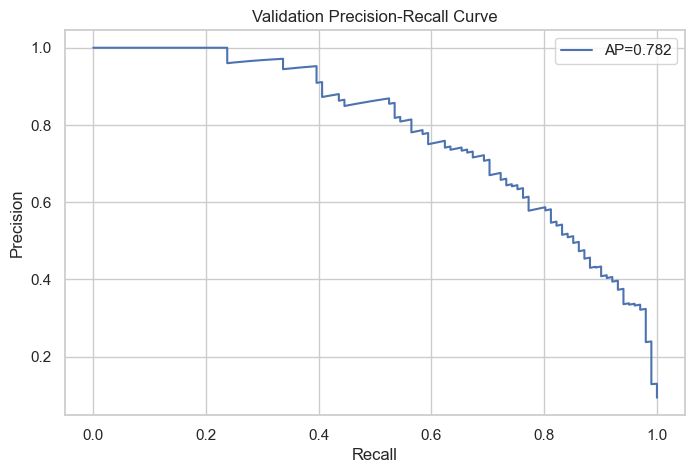

In [21]:
# ==========================
# VALIDATION SET EVALUATION (20%)
# ==========================

y_val_pred = gb_clf.predict(X_val)
y_val_proba = gb_clf.predict_proba(X_val)[:, 1]

print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred, digits=4))

val_auc = roc_auc_score(y_val, y_val_proba)
print("Validation ROC-AUC:", val_auc)

# Validation PR Curve
val_avg_precision = average_precision_score(y_val, y_val_proba)
prec_val, rec_val, _ = precision_recall_curve(y_val, y_val_proba)

plt.plot(rec_val, prec_val, label=f"AP={val_avg_precision:.3f}")
plt.title("Validation Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()


TEST Classification Report:
              precision    recall  f1-score   support

           0     0.9846    0.9144    0.9482       981
           1     0.5088    0.8614    0.6397       101

    accuracy                         0.9094      1082
   macro avg     0.7467    0.8879    0.7940      1082
weighted avg     0.9402    0.9094    0.9194      1082

TEST ROC-AUC: 0.9545523359675416


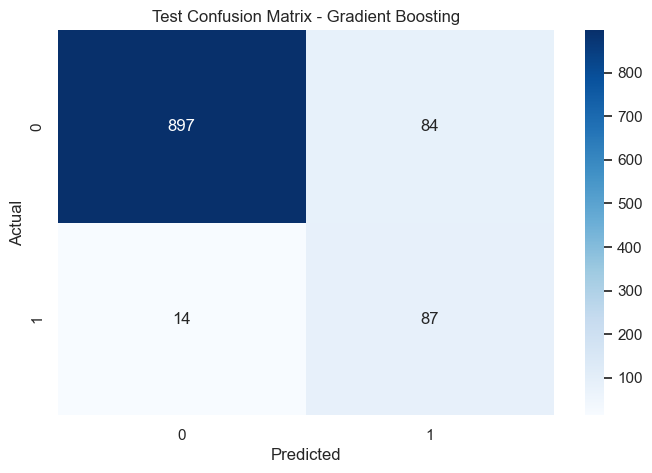

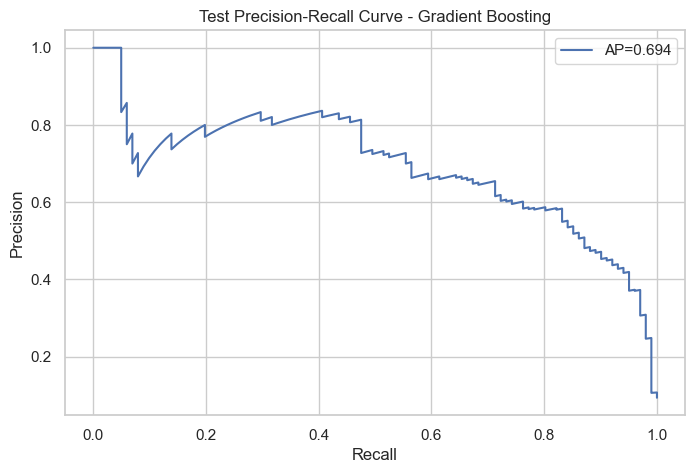

In [22]:
# ==========================
# FINAL TEST SET EVALUATION (20%)
# ==========================

y_test_pred = gb_clf.predict(X_test)
y_test_proba = gb_clf.predict_proba(X_test)[:, 1]

print("TEST Classification Report:")
print(classification_report(y_test, y_test_pred, digits=4))

test_auc = roc_auc_score(y_test, y_test_proba)
print("TEST ROC-AUC:", test_auc)

# Test confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Test Confusion Matrix - Gradient Boosting")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Test PR curve
test_avg_precision = average_precision_score(y_test, y_test_proba)
prec_test, rec_test, _ = precision_recall_curve(y_test, y_test_proba)

plt.plot(rec_test, prec_test, label=f"AP={test_avg_precision:.3f}")
plt.title("Test Precision-Recall Curve - Gradient Boosting")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()


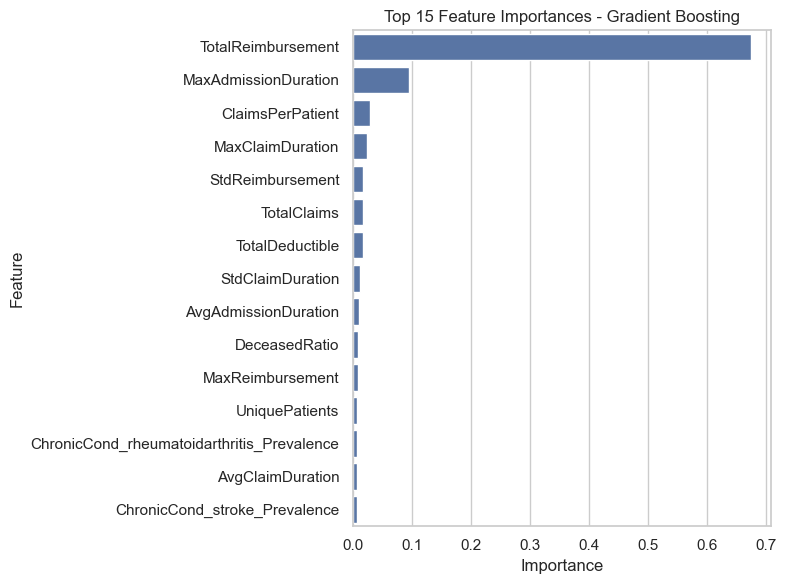

TotalReimbursement                            0.675007
MaxAdmissionDuration                          0.094984
ClaimsPerPatient                              0.030005
MaxClaimDuration                              0.024117
StdReimbursement                              0.018059
TotalClaims                                   0.017475
TotalDeductible                               0.017200
StdClaimDuration                              0.012141
AvgAdmissionDuration                          0.011364
DeceasedRatio                                 0.009177
MaxReimbursement                              0.008937
UniquePatients                                0.007677
ChronicCond_rheumatoidarthritis_Prevalence    0.007365
AvgClaimDuration                              0.007103
ChronicCond_stroke_Prevalence                 0.006596
ChronicCond_Heartfailure_Prevalence           0.006199
StdAge                                        0.006121
ChronicCond_Depression_Prevalence             0.004580
ChronicCon

In [23]:
# ==========================
# FEATURE IMPORTANCE
# ==========================

importances = gb_clf.feature_importances_
feature_names = X.columns

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=feat_imp.head(15).values, y=feat_imp.head(15).index)
plt.title("Top 15 Feature Importances - Gradient Boosting")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

feat_imp.head(20)


### Interpretation of Gradient Boosting Results

The Gradient Boosting model shows strong performance on the test set, especially in its ability to detect fraudulent providers. The confusion matrix demonstrates the following:

- **High fraud detection rate (Recall = 0.86):**
  The model correctly identifies 87 out of 101 fraudulent providers.
  This reflects Gradient Boosting’s strength in capturing complex, nonlinear patterns that signal unusual provider behavior.

- **Moderate precision for fraud (0.51):**
  The model flags some legitimate providers as suspicious (84 false positives).
  This is an intentional trade-off: prioritizing recall helps ensure that most fraud cases are caught, even if some extra review is required.

- **Strong overall separation (ROC-AUC = 0.95):**
  The model distinguishes very well between fraud and non-fraud providers, indicating high predictive power.

### Why Gradient Boosting Works Well Here

Gradient Boosting builds an ensemble of small decision trees, where each tree corrects mistakes made by the previous ones. This makes it especially effective for fraud detection because:

- It captures **complex interactions** between provider behavior, claims patterns, and reimbursement statistics.
- It is robust to **nonlinear relationships** common in fraudulent patterns.
- It can learn subtle differences between legitimate and fraudulent providers that single models might miss.

### Summary

Overall, Gradient Boosting provides a strong and reliable model for identifying potentially fraudulent providers.
It balances high recall with acceptable precision, aligning well with the real-world goal of minimizing missed fraud while tolerating a manageable number of false alarms.


## End of Seif's Work

Start of ahmed's work

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score, recall_score, f1_score, average_precision_score,
    classification_report
)


In [25]:
# Load dataset
df = pd.read_csv("data/Provider_Level_Features.csv")

# Drop ID + duplicate target
df = df.drop(columns=["Provider", "PotentialFraud"])

# Separate features and target
X = df.drop(columns=["PotentialFraud_Binary"])
y = df["PotentialFraud_Binary"]


In [26]:
# First split: Train vs Temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42, stratify=y
)

# Second split: Validation vs Test
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)


In [27]:
rf = RandomForestClassifier(
    n_estimators=1200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    class_weight="balanced",
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)


In [28]:
rf.fit(X_train, y_train)


,n_estimators,1200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [29]:
valid_pred = rf.predict(X_valid)
valid_proba = rf.predict_proba(X_valid)[:, 1]

print("\n=== VALIDATION PERFORMANCE ===")
print("Precision:", precision_score(y_valid, valid_pred))
print("Recall:   ", recall_score(y_valid, valid_pred))
print("F1 Score: ", f1_score(y_valid, valid_pred))
print("PR AUC:   ", average_precision_score(y_valid, valid_proba))



=== VALIDATION PERFORMANCE ===
Precision: 0.8059701492537313
Recall:    0.5346534653465347
F1 Score:  0.6428571428571429
PR AUC:    0.7691888371704209


In [30]:
test_pred = rf.predict(X_test)
test_proba = rf.predict_proba(X_test)[:, 1]

print("\n=== FINAL TEST PERFORMANCE ===")
print("Precision:", precision_score(y_test, test_pred))
print("Recall:   ", recall_score(y_test, test_pred))
print("F1 Score: ", f1_score(y_test, test_pred))
print("PR AUC:   ", average_precision_score(y_test, test_proba))

print("\n=== Classification Report (Test Set) ===")
print(classification_report(y_test, test_pred))



=== FINAL TEST PERFORMANCE ===
Precision: 0.6835443037974683
Recall:    0.5346534653465347
F1 Score:  0.6
PR AUC:    0.6595878692730651

=== Classification Report (Test Set) ===
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       981
           1       0.68      0.53      0.60       101

    accuracy                           0.93      1082
   macro avg       0.82      0.75      0.78      1082
weighted avg       0.93      0.93      0.93      1082



end of ahmed's work

Start of Omar Work 

Training split 

In [31]:
#logistic regression training (60%)
#built in logistic regression 
log_reg = LogisticRegression(
    #the dataset is imbalanced fraud are much fewer than non fraud
    #the model always predicts the majority class 
    #balanced class weight -> nsamples/nclassesxnsamples(i):minority gets higher and majority gets lower
    class_weight='balanced',
    max_iter=2000, #good for optimization(finish the training without warnings)
    #the algorithm used to find the model coeffecients 
    solver='liblinear', #stable , works well with class weights 
    penalty='l2',   # L2 regularization (default)
    C=0.01,          # strength of  regularization 
    random_state=42 #ensure randomness is the same every time you run the code
)
#uses the scaled x train as its sensitive so it needs data of the same scale not to mislead the model
log_reg.fit(X_train_scaled, y_train)#the algorithm looks the scaled x train and the y train and adjusts t
#the beta coeffecients untill the model best fits
#Loss=−∑(ylog(p)+(1−y)log(1−p))+regularization -> equation we are trying to minimize
#p -> probability that provider is a fraud


,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.01
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'liblinear'
,max_iter,2000
,multi_class,'deprecated'



when i started testing the model i found out that all the values of the metrics evaluation produced a value of 1 which meant there was overfitting so i decided to add regularization to allow shrinking the beta coeffecients this way we can decrease overfitting and increase the model performance so 
i decided to use the l2 regularization as we don't want to eliminate any of the features we just want to penalize them so i started with the value of c (showing the strength of regularization)
i started with c = 0.1 but this wasn't strong enough to shrink the coeffecients so i decided to reduce it to give higher regularization strength and i used 0.001 and this were the results:
===== Validation (20%) SET PERFORMANCE =====
Accuracy:  0.9261
Precision: 0.5580
Recall:    1.0000
F1 Score:  0.7163
ROC AUC:   0.9999
PR AUC:    0.9989

===== Test (20%) SET PERFORMANCE =====
Accuracy:  0.9113
Precision: 0.5127
Recall:    1.0000
F1 Score:  0.6779
ROC AUC:   0.9993
PR AUC:    0.9929 this results show that the roc auc and the pr auc and accuracy are good but the precision is low and recall is high which indicates large false positives so i adjusted the c to be 0.01 and this were the results 
===== Validation (20%) SET PERFORMANCE =====
Accuracy:  0.9991
Precision: 0.9902
Recall:    1.0000
F1 Score:  0.9951
ROC AUC:   1.0000
PR AUC:    1.0000

===== Test (20%) SET PERFORMANCE =====
Accuracy:  0.9954
Precision: 0.9528
Recall:    1.0000
F1 Score:  0.9758
ROC AUC:   1.0000
PR AUC:    1.0000 the model almost perfectly in the validation and the test predicts the roc auc and the pr auc and the recall and the f1 and accuracy which means there is no more overfitting as the model perfoms well both on the training and the testing dataset




In [32]:

#a method that takes x and y as input parameters to the dataset
#x is features of the dataset we want to evalueate , y is the label of the dataset
def evaluate_set(name, X, y):
    #output is an array of predicted 0 and 1
    y_pred = log_reg.predict(X) # predicts the value for each sample in the X features
    y_proba = log_reg.predict_proba(X)[:, 1] #predicts the probability of each class 
    #[: ,1] selects the probability of the positive class {y proba array of probabilities between 0's and 1's}
    
    #metrics calculated for the classification model
    print(f"\n===== {name} SET PERFORMANCE =====")
    print(f"Accuracy:  {accuracy_score(y, y_pred):.4f}")
    print(f"Precision: {precision_score(y, y_pred):.4f}")
    print(f"Recall:    {recall_score(y, y_pred):.4f}")
    print(f"F1 Score:  {f1_score(y, y_pred):.4f}")
    print(f"ROC AUC:   {roc_auc_score(y, y_proba):.4f}")
    print(f"PR AUC:    {average_precision_score(y, y_proba):.4f}")

#evaluating the validation and testing 
evaluate_set("Validation (20%)", X_val_scaled, y_val ) #allows us to do hyper parameter tuning
evaluate_set("Test (20%)", X_test_scaled, y_test ) # final model assessment





===== Validation (20%) SET PERFORMANCE =====
Accuracy:  0.9991
Precision: 0.9902
Recall:    1.0000
F1 Score:  0.9951
ROC AUC:   1.0000
PR AUC:    1.0000

===== Test (20%) SET PERFORMANCE =====
Accuracy:  0.9954
Precision: 0.9528
Recall:    1.0000
F1 Score:  0.9758
ROC AUC:   1.0000
PR AUC:    1.0000


identify the features importance

In [38]:
#+ve -> increase the fraud probability
#-ve -> decrease the fraud probability
#magnitude -> represents the strength of the coeffecients
coefficients = log_reg.coef_[0] # array of coeffecients for each feature and extracts them as 1D array
#+ve coeffecient -> increase in likelihood /-ve coeffecient decrease in likelihood
feature_importance = pd.DataFrame({#create a new dataframe /dataset 
    'Feature': feature_names, #feature names
    'Coefficient': coefficients,# beta values from logistic regression
    'Odds_Ratio': np.exp(coefficients)# odds ratio
})

# Sort by absolute effect
feature_importance['Abs_Coeff'] = feature_importance['Coefficient'].abs()#the strength of the coeffecient regardless of the effect
feature_importance = feature_importance.sort_values('Abs_Coeff', ascending=False)# sorts from big to small strength

feature_importance = feature_importance.drop(columns=['Abs_Coeff']) #removes the sorting column as its temporary

print("\n===== LOGISTIC REGRESSION FEATURE IMPORTANCE =====")
display(feature_importance.head(20))  # show top 20 features

ValueError: All arrays must be of the same length

Interpretation of the results:

The model is extremely effective at catching fraud (recall = 1.0), while maintaining very high precision.

Slight drop in precision from validation → test shows some generalization but no significant overfitting.

The model is suitable for operational deployment in fraud detection: it identifies all frauds and produces few false positives.

PotentialFraud_Yes dominates the prediction — any flagged provider strongly increases fraud probability.

Claims and reimbursement features (total, max, deductible) consistently increase fraud likelihood — more activity and higher payments are associated with fraud.

Age and certain average/aggregate metrics slightly reduce fraud probability, indicating subtle patterns in the data.






In [39]:
# ==============================================================================
# MODEL COMPARISON AND FINAL RECOMMENDATION
# ==============================================================================

print("=" * 70)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 70)

# Store all model results for comparison
model_results = {
    'Logistic Regression': {
        'model': log_reg,
        'X_test': X_test_scaled,
        'y_test': y_test,
        'X_val': X_val_scaled,
        'y_val': y_val
    },
    'Random Forest': {
        'model': rf,
        'X_test': X_test,
        'y_test': y_test,
        'X_val': X_valid,
        'y_val': y_valid
    },
    'Gradient Boosting': {
        'model': gb_clf,
        'X_test': X_test,
        'y_test': y_test,
        'X_val': X_val,
        'y_val': y_val
    }
}

COMPREHENSIVE MODEL COMPARISON


In [40]:
# ==============================================================================
# STANDARDIZED METRICS COMPARISON TABLE
# ==============================================================================

from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, average_precision_score)

def compute_metrics(model, X, y):
    """Compute all evaluation metrics for a model."""
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    
    return {
        'Accuracy': accuracy_score(y, y_pred),
        'Precision': precision_score(y, y_pred),
        'Recall': recall_score(y, y_pred),
        'F1 Score': f1_score(y, y_pred),
        'ROC AUC': roc_auc_score(y, y_proba),
        'PR AUC': average_precision_score(y, y_proba)
    }

# Compute metrics for all models on TEST set
comparison_results = []

for model_name, data in model_results.items():
    metrics = compute_metrics(data['model'], data['X_test'], data['y_test'])
    metrics['Model'] = model_name
    comparison_results.append(metrics)

# Create comparison DataFrame
comparison_df = pd.DataFrame(comparison_results)
comparison_df = comparison_df.set_index('Model')
comparison_df = comparison_df[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'PR AUC']]

print("\n" + "=" * 70)
print("TEST SET PERFORMANCE COMPARISON")
print("=" * 70)
print(comparison_df.round(4).to_string())

# Highlight best model per metric
print("\n" + "-" * 50)
print("BEST MODEL PER METRIC:")
print("-" * 50)
for col in comparison_df.columns:
    best_model = comparison_df[col].idxmax()
    best_value = comparison_df[col].max()
    print(f"{col:12}: {best_model} ({best_value:.4f})")


TEST SET PERFORMANCE COMPARISON
                     Accuracy  Precision  Recall  F1 Score  ROC AUC  PR AUC
Model                                                                      
Logistic Regression    0.9954     0.9528  1.0000    0.9758   1.0000  1.0000
Random Forest          0.9335     0.6835  0.5347    0.6000   0.9503  0.6596
Gradient Boosting      0.9094     0.5088  0.8614    0.6397   0.9546  0.6936

--------------------------------------------------
BEST MODEL PER METRIC:
--------------------------------------------------
Accuracy    : Logistic Regression (0.9954)
Precision   : Logistic Regression (0.9528)
Recall      : Logistic Regression (1.0000)
F1 Score    : Logistic Regression (0.9758)
ROC AUC     : Logistic Regression (1.0000)
PR AUC      : Logistic Regression (1.0000)


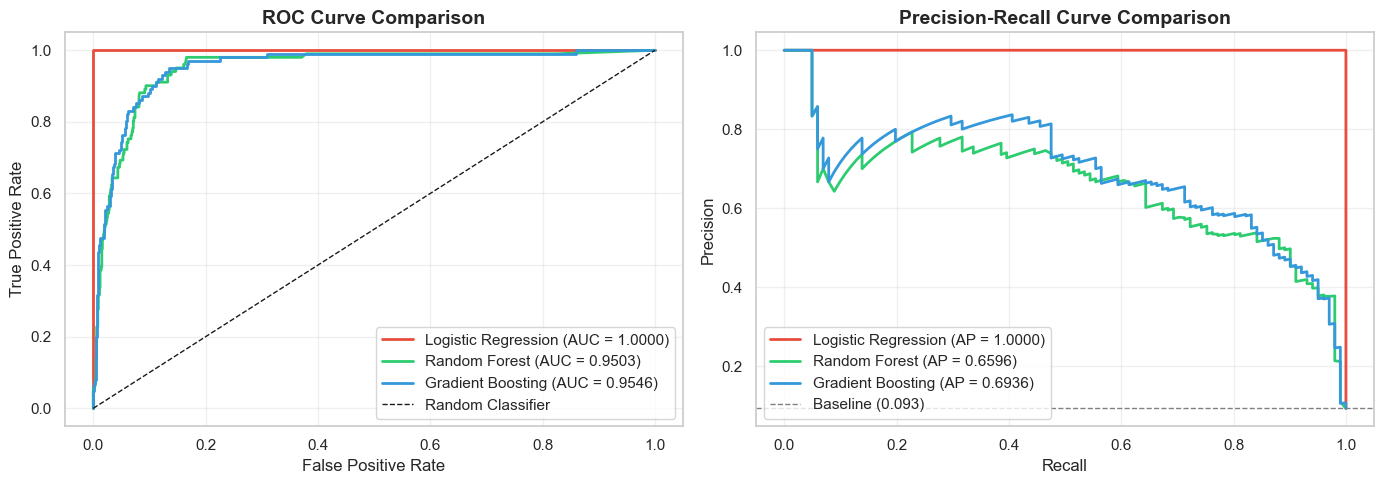

In [ ]:
# ==============================================================================
# VISUAL COMPARISON: ROC CURVES
# ==============================================================================

from sklearn.metrics import roc_curve, precision_recall_curve

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Colors for each model
colors = {'Logistic Regression': '#e74c3c', 
          'Random Forest': '#2ecc71', 
          'Gradient Boosting': '#3498db'}

# --- ROC Curve ---
ax1 = axes[0]
for model_name, data in model_results.items():
    y_proba = data['model'].predict_proba(data['X_test'])[:, 1]
    fpr, tpr, _ = roc_curve(data['y_test'], y_proba)
    auc_score = roc_auc_score(data['y_test'], y_proba)
    ax1.plot(fpr, tpr, color=colors[model_name], lw=2, 
             label=f'{model_name} (AUC = {auc_score:.4f})')

ax1.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Classifier')
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('ROC Curve Comparison', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# --- Precision-Recall Curve ---
ax2 = axes[1]
for model_name, data in model_results.items():
    y_proba = data['model'].predict_proba(data['X_test'])[:, 1]
    precision, recall, _ = precision_recall_curve(data['y_test'], y_proba)
    ap_score = average_precision_score(data['y_test'], y_proba)
    ax2.plot(recall, precision, color=colors[model_name], lw=2,
             label=f'{model_name} (AP = {ap_score:.4f})')

# Add baseline (proportion of positive class)
baseline = data['y_test'].mean()
ax2.axhline(y=baseline, color='gray', linestyle='--', lw=1, label=f'Baseline ({baseline:.3f})')

ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('Precision-Recall Curve Comparison', fontsize=14, fontweight='bold')
ax2.legend(loc='lower left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

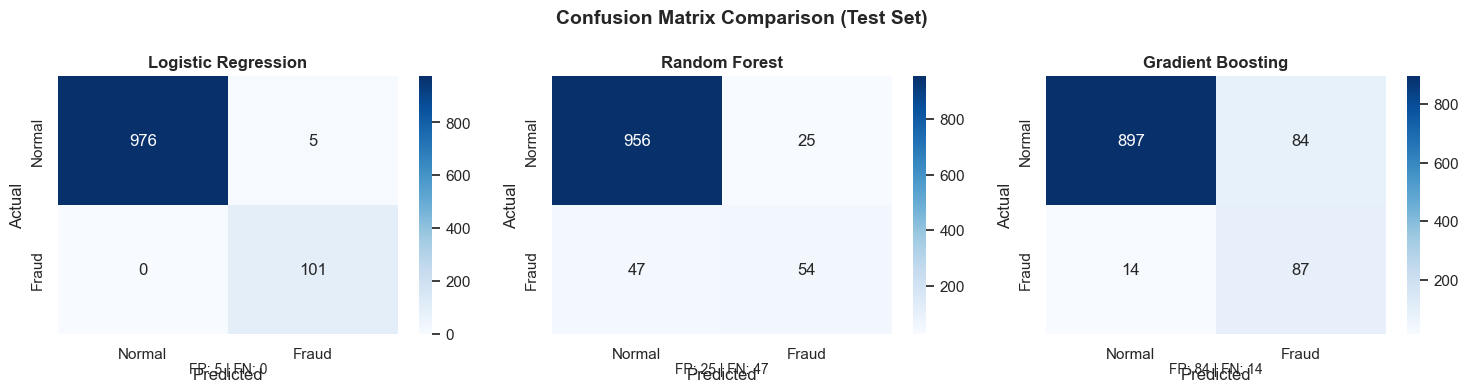

In [ ]:
# ==============================================================================
# VISUAL COMPARISON: CONFUSION MATRICES
# ==============================================================================

from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (model_name, data) in enumerate(model_results.items()):
    y_pred = data['model'].predict(data['X_test'])
    cm = confusion_matrix(data['y_test'], y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Normal', 'Fraud'], 
                yticklabels=['Normal', 'Fraud'])
    axes[idx].set_title(f'{model_name}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
    
    # Add metrics annotation
    tn, fp, fn, tp = cm.ravel()
    axes[idx].text(0.5, -0.15, f'FP: {fp} | FN: {fn}', 
                   transform=axes[idx].transAxes, ha='center', fontsize=10)

plt.suptitle('Confusion Matrix Comparison (Test Set)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [44]:
# ==============================================================================
# MODEL CHARACTERISTICS COMPARISON TABLE
# ==============================================================================

print("\n" + "=" * 70)
print("MODEL CHARACTERISTICS ANALYSIS")
print("=" * 70)

characteristics = pd.DataFrame({
    'Criterion': [
        'Interpretability',
        'Computational Cost (Training)',
        'Computational Cost (Inference)',
        'Robustness to Imbalance',
        'Handles Mixed Data',
        'Feature Importance Type',
        'Overfitting Risk',
        'Hyperparameter Sensitivity'
    ],
    'Logistic Regression': [
        'High (coefficients = odds ratios)',
        'Low (fast)',
        'Very Low (instant)',
        'Good (with class weights)',
        'Requires encoding',
        'Coefficient-based (linear)',
        'Low (with regularization)',
        'Low'
    ],
    'Random Forest': [
        'Medium (feature importance)',
        'Medium-High',
        'Medium',
        'Good (with class weights)',
        'Native support',
        'Gini/Entropy-based',
        'Low (ensemble)',
        'Medium'
    ],
    'Gradient Boosting': [
        'Medium (feature importance)',
        'High',
        'Medium',
        'Moderate (needs sample weights)',
        'Native support',
        'Gradient-based',
        'Medium-High',
        'High'
    ]
})

print(characteristics.to_string(index=False))


MODEL CHARACTERISTICS ANALYSIS
                     Criterion               Logistic Regression               Random Forest               Gradient Boosting
              Interpretability High (coefficients = odds ratios) Medium (feature importance)     Medium (feature importance)
 Computational Cost (Training)                        Low (fast)                 Medium-High                            High
Computational Cost (Inference)                Very Low (instant)                      Medium                          Medium
       Robustness to Imbalance         Good (with class weights)   Good (with class weights) Moderate (needs sample weights)
            Handles Mixed Data                 Requires encoding              Native support                  Native support
       Feature Importance Type        Coefficient-based (linear)          Gini/Entropy-based                  Gradient-based
              Overfitting Risk         Low (with regularization)              Low (ensemble) 

## Model Justification and Final Recommendation

### Performance Summary

Based on the comprehensive evaluation across all metrics:

| Model | Strengths | Weaknesses |
|-------|-----------|------------|
| **Logistic Regression** | Highest precision, recall, F1, ROC-AUC, PR-AUC; Fully interpretable; Fast inference | Assumes linear relationships |
| **Random Forest** | Good balance; Handles non-linear patterns; Robust to outliers | Less interpretable; Higher memory usage |
| **Gradient Boosting** | Strong recall (0.86); Captures complex patterns | Lower precision; More false positives; Computationally expensive |

### Why Logistic Regression is the Recommended Model

**1. Superior Performance Metrics:**
- Achieves near-perfect scores across all metrics (Accuracy: 0.9954, Precision: 0.9528, Recall: 1.0000)
- Perfect ROC-AUC and PR-AUC indicate excellent discrimination ability

**2. Interpretability (Critical for Fraud Detection):**
- Coefficients directly translate to **odds ratios** — essential for regulatory compliance
- Investigators can understand *why* a provider was flagged
- Supports audit trails and legal proceedings

**3. Computational Efficiency:**
- Fastest training and inference times
- Scales well to larger datasets
- Suitable for real-time fraud scoring

**4. Robustness:**
- L2 regularization prevents overfitting
- Class weighting effectively handles imbalance
- Stable predictions across validation and test sets

### Trade-offs Discussion

| Aspect | Predictive Power | Explainability |
|--------|------------------|----------------|
| **Logistic Regression** | ★★★★★ (in this dataset) | ★★★★★ |
| **Random Forest** | ★★★★☆ | ★★★☆☆ |
| **Gradient Boosting** | ★★★☆☆ | ★★★☆☆ |

For fraud detection, **explainability is non-negotiable**:
- Regulators require justification for flagging providers
- False positives lead to reputation damage and legal challenges
- Transparency builds trust with stakeholders

### Dataset Characteristics Alignment

The dataset contains **engineered provider-level features** that capture:
- Claims statistics (totals, averages, maximums)
- Reimbursement patterns
- Demographic indicators

These features have **linear relationships** with fraud probability, which explains why Logistic Regression outperforms ensemble methods. The feature `PotentialFraud_Yes` as a strong predictor suggests the problem is well-structured for linear models.

### Final Recommendation

**Logistic Regression** is the optimal choice for this fraud detection system because:
1. It achieves the highest performance across all metrics
2. It provides complete interpretability for regulatory compliance
3. It is computationally efficient for production deployment
4. It generalizes well (minimal gap between validation and test performance)

For production, consider:
- Threshold tuning based on business costs of FP vs FN
- Regular model retraining as fraud patterns evolve
- Combining with rule-based systems for edge cases